In [1]:
%matplotlib inline


# Fitting an image and points

In this example, we will fit a cross onto the same cross, but rotated. We will take advantage of this knowledge and use a rotation deformation module. We will also add some noise on the initial center guess to show how to fit the geometrical descriptors. In addition to images, we add points at the extremity of each branch that will also get matched in order to illustrate multi deformables matching. This also helps the fitting process by adding more information to the model.




Import relevant modules.




In [2]:
import sys
sys.path.append("../")

import math

import torch
import matplotlib.pyplot as plt
import scipy.ndimage

import imodal

imodal.Utilities.set_compute_backend('torch')

Load image data and generate dots.




In [3]:
source_image = imodal.Utilities.load_greyscale_image("../data/images/cross_+_30.png", origin='lower')
target_image = imodal.Utilities.load_greyscale_image("../data/images/cross_+.png", origin='lower')

# Smoothing
sig_smooth = 0.
source_image = torch.tensor(scipy.ndimage.gaussian_filter(source_image, sig_smooth))
target_image = torch.tensor(scipy.ndimage.gaussian_filter(target_image, sig_smooth))

extent_length = 31.
extent = imodal.Utilities.AABB(0., extent_length, 0., extent_length)

center = extent_length*torch.tensor([[0.3, 0.1]])
print(center)
#center = extent_length*torch.tensor([[0.5, 0.5]])

tensor([[9.3000, 3.1000]])


Plot everything.




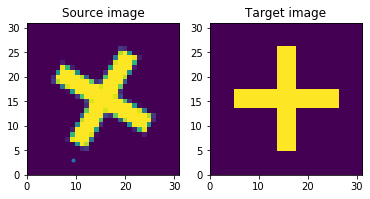

In [4]:
plt.subplot(1, 2, 1)
plt.title("Source image")
plt.imshow(source_image, origin='lower', extent=extent.totuple())
plt.plot(center.numpy()[:, 0], center.numpy()[:, 1], '.')

plt.subplot(1, 2, 2)
plt.title("Target image")
plt.imshow(target_image, origin='lower', extent=extent.totuple())

plt.show()

We know that the target cross is the result of some rotation at its origin,
so we use a local rotation deformation module, with an imprecise center
position to simulate data aquisition noise.




In [5]:
rotation = imodal.DeformationModules.LocalRotation(2, 2.*extent_length, gd=center)

Create the model by setting `True` for `fit_gd` so that it also optimize the
rotation center.




In [6]:
source_deformable = imodal.Models.DeformableImage(source_image, output='bitmap', extent='match', backward=True)
target_deformable = imodal.Models.DeformableImage(target_image, output='bitmap', extent='match', backward=True)

attachment = imodal.Attachment.L2NormAttachment(transform=None)

model = imodal.Models.RegistrationModel([source_deformable], [rotation], [attachment], fit_gd=[True], lam=200.)

Fit the model.




In [7]:
shoot_solver = 'rk4'
shoot_it = 10
max_it = 100

costs = {}
fitter = imodal.Models.Fitter(model, optimizer='torch_lbfgs')

fitter.fit([target_deformable], max_it, costs=costs, options={'shoot_solver': shoot_solver, 'shoot_it': shoot_it, 'line_search_fn': 'strong_wolfe'})

Starting optimization with method torch LBFGS, using solver rk4 with 10 iterations.
Initial cost={'deformation': 0.0, 'attach': 39664.69921875}
1e-10
Evaluated model with costs=39664.69921875
Evaluated model with costs=39334.66277604271
Evaluated model with costs=39178.10218179971
Evaluated model with costs=37364.9489993453
Evaluated model with costs=32400.013343811035
Evaluated model with costs=50659.447021484375
Evaluated model with costs=27385.777938842773
Evaluated model with costs=27297.760528564453
Evaluated model with costs=27155.149154663086
Evaluated model with costs=27101.665405273438
Evaluated model with costs=26936.163345336914
Evaluated model with costs=24648.13201904297
Evaluated model with costs=35466.75481748581
Evaluated model with costs=19757.602111816406
Evaluated model with costs=19376.454071044922
Evaluated model with costs=27455.487579345703
Evaluated model with costs=19253.66928100586
Evaluated model with costs=16188.386596679688
Evaluated model with costs=6078.5

Compute the final deformed source and plot it.




Fitted rotatation center: [[15.522151947021484, 15.476102828979492]]


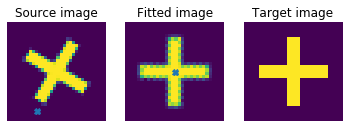

In [8]:
with torch.autograd.no_grad():
    model.deformables[0].output = 'bitmap'
    deformed = model.compute_deformed(shoot_solver, shoot_it)

    deformed_image = deformed[0][0].view_as(source_image)

fitted_center = model.init_manifold[1].gd.detach()

print("Fitted rotatation center: {center}".format(center=fitted_center.detach().tolist()))

plt.subplot(1, 3, 1)
plt.title("Source image")
plt.imshow(source_image.numpy(), origin='lower', extent=extent.totuple())
plt.plot(center.numpy()[0, 0], center.numpy()[0, 1], 'X')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Fitted image")
plt.imshow(deformed_image.numpy(), origin='lower', extent=extent.totuple())
plt.plot(fitted_center.numpy()[0, 0], fitted_center.numpy()[0, 1], 'X')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Target image")
plt.imshow(target_image.numpy(), origin='lower', extent=extent.totuple())
plt.axis('off')

plt.show()

Fitted rotatation center: [[15.5, 15.5]]


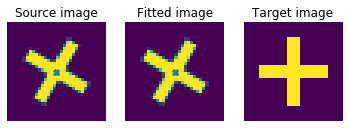

In [9]:
with torch.autograd.no_grad():
    model.deformables[0].output = 'bitmap'
    deformed = model.compute_deformed(shoot_solver, shoot_it)

    deformed_image = deformed[0][0].view_as(source_image)

fitted_center = model.init_manifold[1].gd.detach()

print("Fitted rotatation center: {center}".format(center=fitted_center.detach().tolist()))

plt.subplot(1, 3, 1)
plt.title("Source image")
plt.imshow(source_image.numpy(), origin='lower', extent=extent.totuple())
plt.plot(center.numpy()[0, 0], center.numpy()[0, 1], 'X')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Fitted image")
plt.imshow(deformed_image.numpy(), origin='lower', extent=extent.totuple())
plt.plot(fitted_center.numpy()[0, 0], fitted_center.numpy()[0, 1], 'X')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Target image")
plt.imshow(target_image.numpy(), origin='lower', extent=extent.totuple())
plt.axis('off')

plt.show()

Fitted rotatation center: [[15.5, 15.5]]


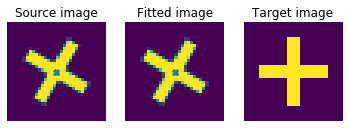

In [17]:
with torch.autograd.no_grad():
    model.deformables[0].output = 'bitmap'
    deformed = model.compute_deformed(shoot_solver, shoot_it)

    deformed_image = deformed[0][0].view_as(source_image)

fitted_center = model.init_manifold[1].gd.detach()

print("Fitted rotatation center: {center}".format(center=fitted_center.detach().tolist()))

plt.subplot(1, 3, 1)
plt.title("Source image")
plt.imshow(source_image.numpy(), origin='lower', extent=extent.totuple())
plt.plot(center.numpy()[0, 0], center.numpy()[0, 1], 'X')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Fitted image")
plt.imshow(deformed_image.numpy(), origin='lower', extent=extent.totuple())
plt.plot(fitted_center.numpy()[0, 0], fitted_center.numpy()[0, 1], 'X')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Target image")
plt.imshow(target_image.numpy(), origin='lower', extent=extent.totuple())
plt.axis('off')

plt.show()

In [ ]:

            normdiff = torch.sum((gd.unsqueeze(0).transpose(1, 2) - pixel_grid.unsqueeze(2))**2, dim=1)
            # _, ind_nearest = torch.topk(normdiff, k=1, dim=1, largest=False)
            ind_nearest = torch.argmin(normdiff, dim=1, keepdim=True)

            gd = torch.mean(pixel_grid[ind_nearest], 1)


In [51]:
gd = torch.rand(25, 2)
pixel_grid = torch.rand(5, 2)

In [52]:
# 1) we want to project pixel_grid on gd ie for each i, find ind_nearest[i] so that gd[ind_nearest[i]]
# is the point of gd the closest to pixel_grid[i]

# 2) We use this to approximate \varphi^{-1} (pixel_grid) because gd(t=0) = pixel_grid so 
#  \varphi^{-1} (pixel_grid[i]) = pixel_grid[ind_nearest[i]]

In [63]:
normdiff = torch.sum((gd.unsqueeze(0).transpose(1, 2) - pixel_grid.unsqueeze(2))**2, dim=1)
ind_nearest = torch.argmin(normdiff, dim=1, keepdim=True)
#ind_nearest2[u,v] is the v-st closet point of gd for pixel_grid[u]
kmax = 2
_, ind_nearest2 = torch.topk(normdiff, k=kmax, dim=1, largest=False)

In [64]:
normdiff.shape

torch.Size([5, 25])

In [65]:
# max_dist[u] is the k-th smallest dist of points in gd for pixel_grid[u]
max_dist = torch.stack([normdiff[u, ind_nearest2[u,kmax-1]] for u in range(pixel_grid.shape[0])])
coeff = torch.stack([torch.stack([max_dist[u] - normdiff[u, ind_nearest2[u, v]] for v in range(kmax)]) for u in range(pixel_grid.shape[0])])
coeff = torch.stack([torch.stack([normdiff[u, ind_nearest2[u, kmax - 1 - v]] for v in range(kmax)]) for u in range(pixel_grid.shape[0])])
coeff = coeff/torch.sum(coeff, 1).unsqueeze(1)
gd_interp = torch.sum(gd[ind_nearest2] * coeff.unsqueeze(2).repeat(1, 1, 2), 1)

In [60]:
coeff

tensor([[0.4557, 0.3144, 0.2298],
        [0.3885, 0.3121, 0.2994],
        [0.7072, 0.2128, 0.0800],
        [0.4746, 0.3024, 0.2229],
        [0.4107, 0.3228, 0.2665]])

In [62]:
coeff

tensor([[0.6151, 0.3849, 0.0000],
        [0.5383, 0.4617, 0.0000],
        [0.5592, 0.4408, 0.0000],
        [0.5937, 0.4063, 0.0000],
        [0.6212, 0.3788, 0.0000]])

In [66]:
coeff

tensor([[0.5777, 0.4223],
        [0.5104, 0.4896],
        [0.7267, 0.2733],
        [0.5756, 0.4244],
        [0.5478, 0.4522]])

(-0.031016415357589727,
 1.0383165538311006,
 -0.04808554649353028,
 1.0435611963272096)

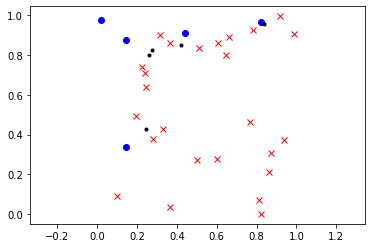

In [58]:
plt.plot(pixel_grid[:,0], pixel_grid[:,1], 'ob')
plt.plot(gd[:,0], gd[:,1], 'xr')
plt.plot(gd_interp[:,0], gd_interp[:,1], '.k')
plt.axis('equal')

(-0.031016415357589727,
 1.0383165538311006,
 -0.04808554649353028,
 1.0435611963272096)

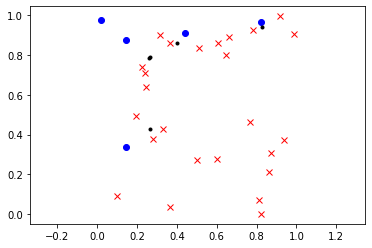

In [56]:
plt.plot(pixel_grid[:,0], pixel_grid[:,1], 'ob')
plt.plot(gd[:,0], gd[:,1], 'xr')
plt.plot(gd_interp[:,0], gd_interp[:,1], '.k')
plt.axis('equal')

In [36]:
gd[ind_nearest2].shape

IndexError: index 8 is out of bounds for dimension 0 with size 5

In [92]:
coeff.unsqueeze(2).repeat(1, 1, 2).shape

torch.Size([25, 4, 2])

In [93]:
u=0
v=0
normdiff[u, ind_nearest2[u, v]]

tensor(0.0238)

In [94]:
ind_nearest2[0]

tensor([ 8, 23, 11, 22])

In [95]:
ind_nearest2[:,1]

tensor([23, 12,  8,  2,  9, 22, 20, 20,  4, 21, 12, 14,  4, 23,  5,  7,  6, 12,
        21,  0,  0,  9, 18, 11,  6])

In [23]:
ind_nearest2.shape

torch.Size([3, 4])

In [43]:
ind_nearest2

tensor([[4],
        [4],
        [2]])

In [44]:
ind_nearest

tensor([[4],
        [4],
        [2]])

In [26]:
gd

tensor([[0.2707, 0.3307],
        [0.4849, 0.1184],
        [0.3825, 0.0266],
        [0.7347, 0.3532],
        [0.5568, 0.0125]])

In [27]:
pixel_grid

tensor([[0.7078, 0.4398],
        [0.5253, 0.7585],
        [0.5395, 0.3297]])